```bash
pip install polars

# Or for legacy CPUs without AVX2 support
pip install polars-lts-cpu
```

In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import KarateClub
from torch_geometric.nn import GCNConv

In [2]:


# --- 1️⃣ Chargement du dataset ---
dataset = KarateClub()
data = dataset[0]
print(data)
# → Data(x=[34, 34], edge_index=[2, 156], y=[34])



Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])


In [3]:

# --- 2️⃣ Définition du modèle ---
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_features, 16)  # 34 → 16
        self.conv2 = GCNConv(16, dataset.num_classes)   # 16 → 4 classes

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)



In [4]:
# --- 3️⃣ Entraînement ---
model = GCN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()

GCN(
  (conv1): GCNConv(34, 16)
  (conv2): GCNConv(16, 4)
)

In [5]:

for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out, data.y)
    loss.backward()
    optimizer.step()

print("🔹 Perte finale :", loss.item())


🔹 Perte finale : 0.058803025633096695


In [6]:

# --- 4️⃣ Prédictions ---
model.eval()
pred = out.argmax(dim=1)
correct = (pred == data.y).sum()
acc = int(correct) / len(data.y)
print(f"✅ Précision : {acc:.2f}")

✅ Précision : 1.00


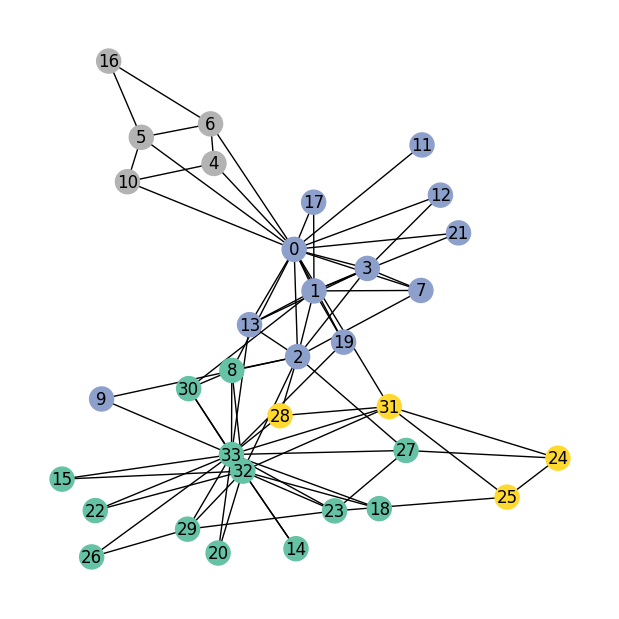

In [7]:


# --- 5️⃣ Visualisation (optionnel) ---
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx
import networkx as nx

G = to_networkx(data, to_undirected=True)
plt.figure(figsize=(6, 6))
nx.draw(G, node_color=pred, with_labels=True, cmap="Set2")
plt.show()